# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.<br>
**Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

*Considero que el Proyecto podría entenderse como un problema de multi-clasificación, donde cada clase corresponde a un valor de estrella. No sería del todo preciso usar regresión porque no buscamos valores continuos, sino más bien discretos y que agrupen a las reseñas según el tipo de valoración que representan.*

## Objetivo del Proyecto
Implementar un modelo para reconocer el puntaje asignado por un usuario a un item de Amazon  partir de su crítica.
#### Importamos las librerías necesarias y el dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Importamos dataset de entrenamiento
data = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)

Exploramos el dataset:

In [3]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [4]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
199995,es_0715276,product_es_0317036,reviewer_es_0643604,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,es,electronics
199996,es_0085190,product_es_0622919,reviewer_es_0466173,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,es,electronics
199997,es_0484496,product_es_0358101,reviewer_es_0330744,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,es,apparel
199998,es_0930141,product_es_0788855,reviewer_es_0694290,5,Perfecto para el cumple de mi hijo,Recomendado,es,toy
199999,es_0859809,product_es_0378794,reviewer_es_0141717,5,"Súper bien! Las brochas son buenas, no sé meno...",Preciosas,es,home


In [5]:
data.shape

(200000, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


#### Importamos librerías SpaCy y NLTK

Luego de investigar en la documentación de SpaCy y NLTK para ver cuáles stopwords eran más convenientes, vi que [SpaCy](https://github.com/explosion/spaCy/blob/master/spacy/lang/es/stop_words.py) era más completa que [NLTK](https://github.com/Alir3z4/stop-words/blob/bd8cc1434faeb3449735ed570a4a392ab5d35291/spanish.txt). Leyendo un poco sobre eso, descubrí que están sacadas del ámbito de las noticias y por eso tienen más vocabulario que forme parte de las 'stopwords'.

La librería NLTK es más acotada pero clásica, con palabras que bien podrían saltearse en un procesamiento de lenguaje natural. Lo que sí, ambas tienen palabras que nos podrían servir para predecir el valor de una reseña, como 'no', 'bueno', 'buena' y 'buen'.

Para este proyecto voy a elegir **SpaCy** por ser más completa, pero no descarto la posibilidad de entrenarlo con las stopwords de NLTK para evaluar si mejora en algo.

También iré alternando de librerías para los distintos procesos según la facilidad con la que se pueda utilizar cada una.

In [7]:
# Previamente
## python -m spacy download es
## python -m spacy download es_core_news_sm

import spacy # https://spacy.io/usage/models
nlp = spacy.load('es_core_news_sm')

#Stop Words de es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no')
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')

In [8]:
import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('spanish'))

# Quitamos de las stopwords la palabra 'no', que nos puede ser últil para predecir
stopwords_nltk.remove('no')

import re
from nltk.tokenize import RegexpTokenizer

### Análisis Exploratorio de Datos
#### Algunas preguntas que van surgiendo...
##### 1. ¿Cuántos tipos de productos hay en el dataset?

In [9]:
data.product_category.value_counts()

home                        26962
wireless                    25886
toy                         13647
sports                      13189
pc                          11191
home_improvement            10879
electronics                 10385
beauty                       7337
automotive                   7143
kitchen                      6695
apparel                      5737
drugstore                    5513
book                         5264
furniture                    5229
baby_product                 4881
office_product               4771
lawn_and_garden              4237
other                        3937
pet_products                 3713
personal_care_appliances     3573
luggage                      3328
camera                       3029
shoes                        2754
digital_ebook_purchase       1843
video_games                  1733
jewelry                      1598
musical_instruments          1530
watch                        1490
industrial_supplies          1482
grocery       

##### 2. ¿Cuántas reseñas hay por cada estrella según la categoría?

In [10]:
data_grouped = data.review_id.groupby([data['product_category'],data['stars']]).count().astype(int).reset_index(name='count')
data_grouped

,product_category,stars,count
0,apparel,1,1273
1,apparel,2,1205
2,apparel,3,1200
3,apparel,4,1131
4,apparel,5,928
...,...,...,...
145,wireless,1,6283
146,wireless,2,5684
147,wireless,3,4797
148,wireless,4,4606


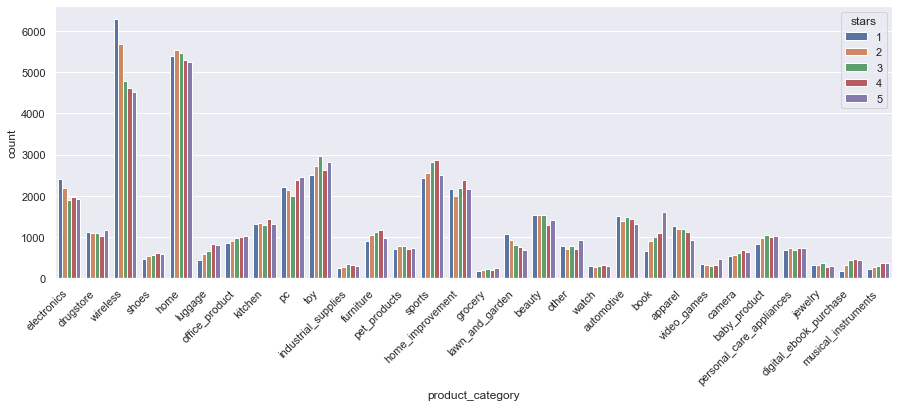

In [11]:
# Visualización
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=data['product_category'],data=data, hue='stars')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

##### 3. ¿Cuál es el promedio de estrellas por cada categoría? Así es más fácil visualizar. <br>
*La media debería dar alrededor de 3, pero aquellos que estén por debajo significa que fueron en su mayoría peor calificados. Inversamente sucede con los que están por encima de 3, lo que significa que fueron en su mayoría muy bien calificados.*

In [12]:
from statistics import mean
data_grouped = data.stars.groupby([data['product_category']]).mean().reset_index(name='avg_stars')
data_grouped['rev_count'] = data.stars.groupby([data['product_category']]).count().astype(int).reset_index(name='rev_count').rev_count
data_grouped.sort_values(by='avg_stars')

,product_category,avg_stars,rev_count
16,lawn_and_garden,2.773189,4237
29,wireless,2.821834,25886
0,apparel,2.866829,5737
8,electronics,2.887626,10385
14,jewelry,2.930538,1598
3,beauty,2.935805,7337
1,automotive,2.950721,7143
11,home,2.980380,26962
23,pet_products,2.991112,3713
28,watch,3.001342,1490


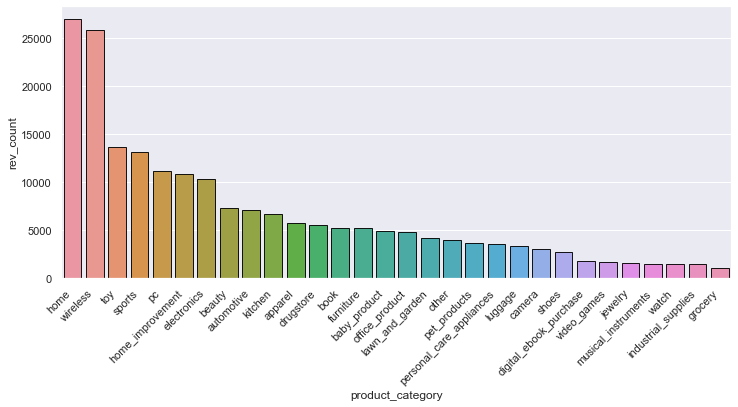

In [14]:
# Visualización de cantidad de reseñas por categoría
data_grouped.sort_values(['rev_count','avg_stars'],ascending=False,inplace=True)
plt.figure(figsize=(12,5))
grafico = sns.barplot(x=data_grouped.product_category, y=data_grouped.rev_count, linewidth=0.9,edgecolor=(0,0,0))
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

##### 4. ¿Cuántas reviews hay por cada valoración?

In [15]:
data.stars.value_counts()

1    40000
2    40000
3    40000
4    40000
5    40000
Name: stars, dtype: int64

*Vemos que está equilibrada la cantidad de cada una.*

##### 5. ¿Cuántos usuarios únicos publicaron en este dataset?

In [16]:
# Ver cuántos usuarios únicos publicaron
unique_usrs = len(data.reviewer_id.unique())
print("De las", data.shape[0],"reseñas, sólo", unique_usrs, "fueron hechas por usuarios únicos.")
print("Esto equivale al", unique_usrs/data.shape[0]*100,"%")

De las 200000 reseñas, sólo 179076 fueron hechas por usuarios únicos.
Esto equivale al 89.538 %


##### 6. ¿Cuántos productos únicos aparecen en las reseñas?

In [17]:
# Ver sobre cuántos productos únicos se publicaron reseñas
unique_prods = len(data.product_id.unique())
print("De las", data.shape[0],"reseñas, sólo se mencionan", unique_prods , "productos únicos.")
print("Esto equivale al", unique_prods/data.shape[0]*100,"%")

De las 200000 reseñas, sólo se mencionan 150938 productos únicos.
Esto equivale al 75.469 %


##### 7. Tomamos como ejemplo un usuario y analizamos su actividad

In [18]:
# Vemos las reseñas de un solo usuario
rand_idx = np.random.randint(0,data.shape[0])
usr = data.reviewer_id.iloc[rand_idx]
usr_data = data[data.reviewer_id == usr]
print("Cantidad de reseñas del usuario", usr,":", len(usr_data))
print("Promedio de estrellas que ha dado:", usr_data.stars.mean())
usr_data[['reviewer_id','product_category','review_title','review_body','stars']]

Cantidad de reseñas del usuario reviewer_es_0434711 : 1
Promedio de estrellas que ha dado: 4.0


,reviewer_id,product_category,review_title,review_body,stars
127493,reviewer_es_0434711,wireless,CUMPLE ESPECTATIVAS,Relación calidad-precio excelente. Un poco len...,4


##### 8. ¿Cuáles son las palabras más frecuentes por cada valoración?
Para responder a esto neceitamos importar la librería NLTK para el procesamiento del lenguaje natural.

In [19]:
# Separamos en distintos dataframes las reviews según valoración
data_star_1 = data[data['stars']==1]
data_star_2 = data[data['stars']==2]
data_star_3 = data[data['stars']==3]
data_star_4 = data[data['stars']==4]
data_star_5 = data[data['stars']==5]

Empezamos analizando las reviews de 1 estrella:

In [22]:
todas_reviews_1 = []
for i in data_star_1.index:
    review1 = data_star_1.review_body[i] #seleccionar el titular
    review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
    review1 = [w.lower() for w in review1 if w not in stopwords_spacy] # Filtrar por stopwords
    review1 = [w.lower() for w in review1 if len(w)>3 or w=='no' ] # Filtrar a las que tienen menos de 3 caracteres, salvo el 'no'
    todas_reviews_1.append(review1) #agregar el resultado a la lista

print('Cantidad de palabras filtradas:',len(todas_reviews_1))
todas_reviews_1[:3]

Cantidad de palabras filtradas: 40000


[['nada',
  'bueno',
  'pantalla',
  'meses',
  'no',
  'recibido',
  'respuesta',
  'fabricante'],
 ['horrible',
  'tuvimos',
  'comprar',
  'inglés',
  'informático',
  'hora',
  'capaz',
  'instalarlo'],
 ['obligan',
  'comprar',
  'unidades',
  'llega',
  'no',
  'forma',
  'reclamar',
  'autentica',
  'estafa',
  'no',
  'compreis']]

In [23]:
# Esta celda convierte una lista de listas en una unica lista
import itertools
plain_todas_reviews_1 = list(itertools.chain(*todas_reviews_1))
print('Cantidad de palabras luego de aplanar:', len(plain_todas_reviews_1))
plain_todas_reviews_1[0:10]

Cantidad de palabras luego de aplanar: 466923


['nada',
 'bueno',
 'pantalla',
 'meses',
 'no',
 'recibido',
 'respuesta',
 'fabricante',
 'horrible',
 'tuvimos']

In [24]:
# Obtenemos frecuencia de palabras y creamos nuevo df
freq_rev_1 = nltk.FreqDist(plain_todas_reviews_1)
df_rev_frec_1 = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_rev_frec_1.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_rev_frec_1.reset_index(drop = True, inplace=True)
df_rev_frec_1.head()

,Palabra,Frecuencia
0,no,47970
1,producto,7219
2,calidad,4349
3,llegado,3422
4,recomiendo,2812


In [25]:
# Vemos la parte inferior
df_rev_frec_1[df_rev_frec_1['Frecuencia']<10]

,Palabra,Frecuencia
4897,narices,9
4898,tapacubos,9
4899,reconocida,9
4900,poderse,9
4901,encontrarlo,9
...,...,...
26677,tebeos,1
26678,olaf,1
26679,inmoviliza,1
26680,alucino,1


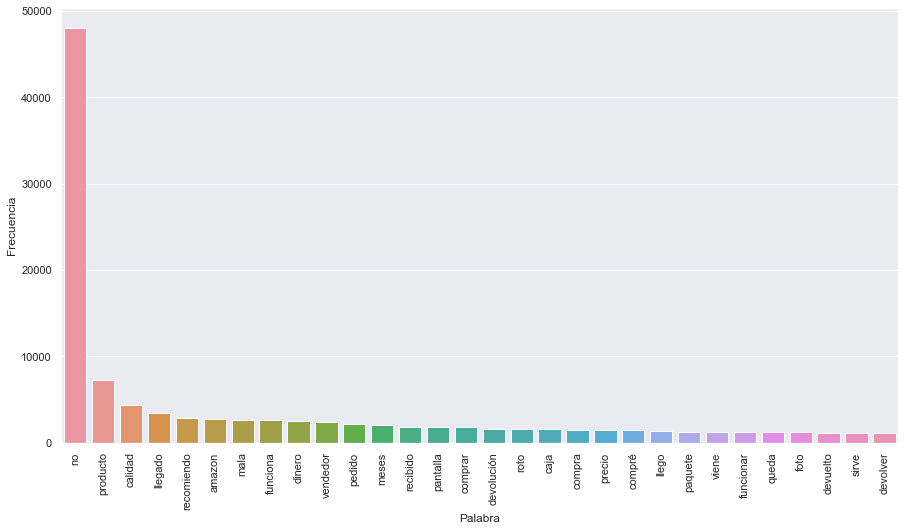

In [26]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[:30].Palabra, y = df_rev_frec_1.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

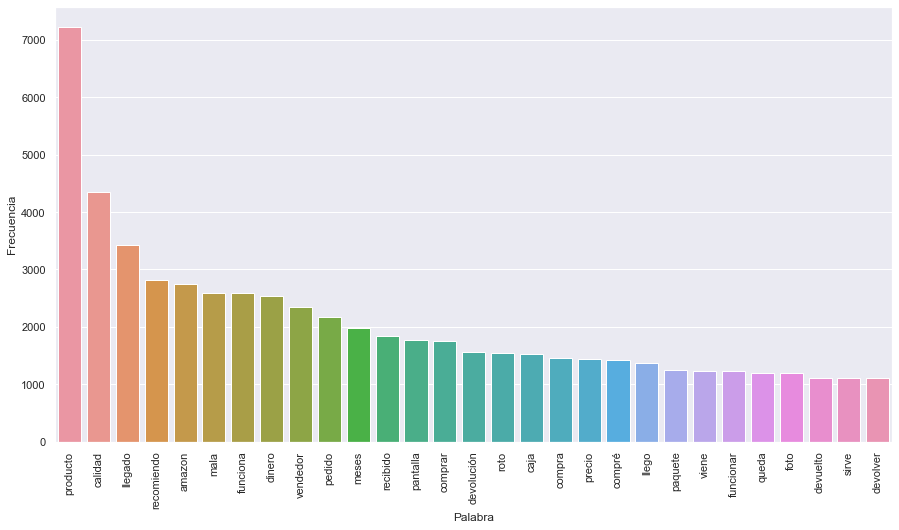

In [29]:
# Filtramos la palabra 'no' que es ampliamente más frecuente para visualizar mejor
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[1:30].Palabra, y = df_rev_frec_1.iloc[1:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Para procesar los restantes dataframes, agrupamos todas las operaciones en una sola función:

In [37]:
def word_frecquency_df(dataframe):
    todas_reviews = []
    for i in dataframe.index:
        review1 = dataframe.review_body[i] #seleccionar el titular
        review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
        review1 = [w.lower() for w in review1 if w not in stopwords_spacy] # Filtrar por stopwords
        review1 = [w.lower() for w in review1 if len(w)>3 or w=='no' ] # Filtrar a las que tienen menos de 3 caracteres, salvo el 'no'
        todas_reviews.append(review1) # Agregar el resultado a la lista
    plain_todas_reviews = list(itertools.chain(*todas_reviews)) # Aplanar la lista
    freq_revs = nltk.FreqDist(plain_todas_reviews) # Obtener frecuencia por palabra
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['Palabra', 'Frecuencia']) # Crear nuevo df
    df_revs.sort_values(by=['Frecuencia'], inplace=True, ascending=False) # Ordenar valores por frecuencia
    df_revs.reset_index(drop = True, inplace=True) # Resetear index
    return df_revs

In [39]:
# Aplicamos la función a los demás df
df_rev_frec_2 = word_frecquency_df(data_star_2)
df_rev_frec_3 = word_frecquency_df(data_star_3)
df_rev_frec_4 = word_frecquency_df(data_star_4)
df_rev_frec_5 = word_frecquency_df(data_star_5)

In [40]:
df_rev_frec_2

,Palabra,Frecuencia
0,no,43464
1,calidad,5874
2,producto,4651
3,precio,3253
4,buena,2227
...,...,...
29320,trabajase,1
29321,ocre,1
29322,relató,1
29323,latinos,1


Visualización: <br>
**Para reviews de 2 estrellas:** No incluimos la palabra 'no' que es la más frecuente para que se vea más claro

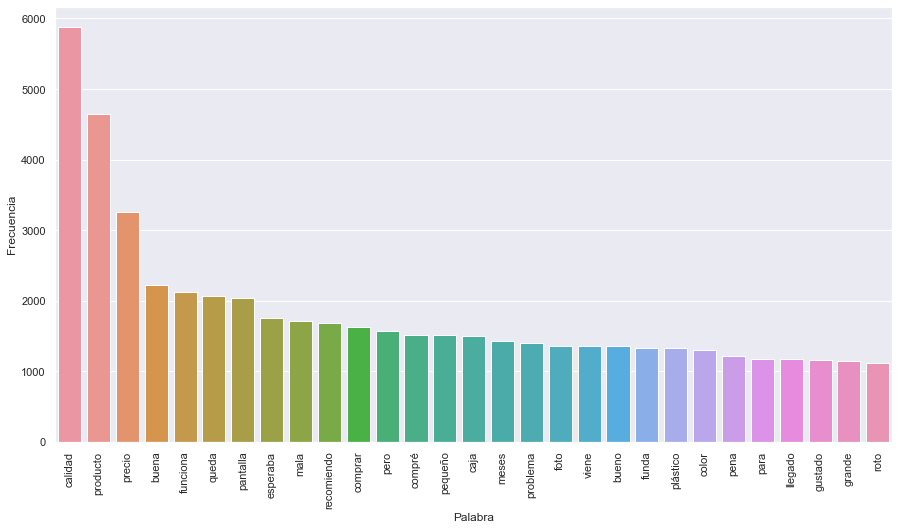

In [41]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_2.iloc[1:30].Palabra, y = df_rev_frec_2.iloc[1:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Preprocesamiento
#### Importamos el dataset
Volvemos a importar el dataset y nos quedamos con las columnas relevantes.

In [ ]:
data = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)
df = data[['product_category','review_title','review_body','stars']]
df.head()

In [ ]:
# Miramos una review al azar
random_index = np.random.randint(0,df.shape[0])
review = df.review_body.iloc[random_index]
title = df.review_title.iloc[random_index]
print(random_index, title, '\n',review)
print('Puntuación:',df.stars[random_index])
print('Categoría:', df.product_category[random_index])

#### Tokenización y Lemmatización

In [ ]:
#Constante de signos de puntuación
import string
puntua = string.punctuation + '¡¿'

In [ ]:
#Función para limpieza de datos
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if (token.lemma_ != "-PRON-" and token.pos_ != "NUM"): # Qué hace esto?? --> Así identifica el lemma a los pronombres https://www.geeksforgeeks.org/python-pos-tagging-and-lemmatization-using-spacy/
            temp = token.lemma_.strip()
            tokens.append(temp.lower())
    
    clean_tokens = []
    for token in tokens:
        if str(token) not in stopwords_spacy and token not in puntua:
            clean_tokens.append(token)
    
    return clean_tokens

In [ ]:
# Limpiamos la review escogida
clean_review = text_data_cleaning(review)
clean_review